## 0. Imports

In [22]:
from time import time
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords as sw
nltk.download('stopwords') ## à executer qu'une fois
stopwords = sw.words('english')

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
### models ML
from sklearn.svm import SVC, LinearSVC     # Support Vector Machine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Connection to mongodb

In [3]:
from pymongo import MongoClient
client = MongoClient("localhost", 27017)
db = client["StarkBotBD"]
db.Quest_Rep.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)], 'ns': 'StarkBotBD.Quest_Rep'},
 'text_search': {'v': 2,
  'key': [('_fts', 'text'), ('_ftsx', 1)],
  'ns': 'StarkBotBD.Quest_Rep',
  'weights': SON([('Body', 1), ('Title', 2)]),
  'default_language': 'english',
  'language_override': 'language',
  'textIndexVersion': 3},
 'Topic_1': {'v': 2, 'key': [('Topic', 1)], 'ns': 'StarkBotBD.Quest_Rep'},
 'Score_1': {'v': 2, 'key': [('Score', 1)], 'ns': 'StarkBotBD.Quest_Rep'},
 'PostTypeId_1': {'v': 2,
  'key': [('PostTypeId', 1)],
  'ns': 'StarkBotBD.Quest_Rep'},
 'ParentId_1': {'v': 2,
  'key': [('ParentId', 1)],
  'ns': 'StarkBotBD.Quest_Rep'},
 'AnswerCount_1': {'v': 2,
  'key': [('AnswerCount', 1)],
  'ns': 'StarkBotBD.Quest_Rep'},
 'Id_1': {'v': 2, 'key': [('Id', 1)], 'ns': 'StarkBotBD.Quest_Rep'}}

In [7]:
## Liste des Topic dans la BDD
topic = 'general'
languages = ['english', 'french']
le = LabelEncoder()
le.fit(languages)

LabelEncoder()

## 2. Corpus and Targets generation
Query mongodb BDD to create a liste of questions (corpus). 

In [11]:
nq_by_topic = 5000
corpus = []
target = []
for language in languages:
    if db.Quest_Rep.find({"Topic": topic, 'Language':language, "PostTypeId":"1"}).count()>=nq_by_topic:
        elmts_cursor = db.Quest_Rep.find({"Topic": topic, 'Language':language, "PostTypeId":"1"}) \
                                        .sort([('Score', -1)]).limit(nq_by_topic)
        corpus.extend([elmt.get("Title") for elmt in elmts_cursor])
        target.extend([language]*nq_by_topic)
    else:
        length = db.Quest_Rep.find({"Topic": topic, 'Language':language, "PostTypeId":"1"}).count()
        elmts_cursor = db.Quest_Rep.find({"Topic": topic, 'Language':language, "PostTypeId":"1"}) \
                                        .sort([('Score', -1)]).limit(length)
        corpus.extend([elmt.get("Title") for elmt in elmts_cursor])
        target.extend([language]*length)

<ipython-input-11-9f1583c7966f>:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if db.Quest_Rep.find({"Topic": topic, 'Language':language, "PostTypeId":"1"}).count()>=nq_by_topic:
<ipython-input-11-9f1583c7966f>:11: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  length = db.Quest_Rep.find({"Topic": topic, 'Language':language, "PostTypeId":"1"}).count()


In [12]:
corpus = np.array(corpus)
corpus

array(['What is AI?', 'What is AI?', 'Are you sentient?', ...,
       "De quel pays, God Save the Queen est l'hymne national?",
       'Le Plateau Celte, le fond marin sous la mer Celtique est une partie du plateau continental de quel continent?',
       'Les dauphins utilisent un sens, proche du sonar, pour déterminer la position et la forme des objets environnant.'],
      dtype='<U182')

In [13]:
target = np.array(target)
target

array(['english', 'english', 'english', ..., 'french', 'french', 'french'],
      dtype='<U7')

In [14]:
## Taille des differents topics
for language in languages:
    somme = db.Quest_Rep.find({"Topic": topic, 'Language':language, "PostTypeId":"1"}).count()
    print(somme)

2619
107


<ipython-input-14-d2e5a882666d>:3: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  somme = db.Quest_Rep.find({"Topic": topic, 'Language':language, "PostTypeId":"1"}).count()


In [15]:
## encode targets (str) to numerical (int)
y = le.transform(target)

In [17]:
vect = CountVectorizer(stop_words=None)
X = vect.fit_transform(corpus)

In [18]:
X.shape

(2726, 1137)

In [19]:
def run_pipes(pipes, splits, corpus, targets, test_size=0.2, seed=42):  
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed)
    for idx_train, idx_test in spliter.split(corpus, targets):
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])
            
            # extract datasets
            X_train = corpus[idx_train]
            X_test = corpus[idx_test]
            y_train = targets[idx_train]
            y_test = targets[idx_test]
            
            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start
            
            # predict and save results
            y = pipe.predict(X_test)
            res[name].append([
                fit_time,
                f1_score(y_test, y, average='micro'),
                f1_score(y_test, y, average='macro'),
                f1_score(y_test, y, average='weighted'),           
            ])
    return res


In [20]:
def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time (s)" : arr[:, 0].mean(),#.round(2),
            "f1_av_micro": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "f1_av_macro": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],
            "f1_av_weighted": [arr[:,3].mean().round(3), arr[:,3].std().round(3)],
        }

    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [23]:
from sklearn.metrics import f1_score
pipe0 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('sgd-weight_bal', SGDClassifier(max_iter = 2000, class_weight = 'balanced', penalty= 'elasticnet', loss = 'modified_huber')), #penalty{‘l2’, ‘l1’, ‘elasticnet’}
])                          # loss  ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.
pipe1 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('lin_svm-weight_bal', LinearSVC(class_weight = 'balanced', penalty='l1', loss = 'squared_hinge', dual=False)), # penalty{‘l1’, ‘l2’}: default : 'l2', loss{‘hinge’, ‘squared_hinge’} : default: 'square_hinge'
])                                                                                                                  # must : , penalty='l1', loss = 'squared_hinge', dual=False
pipe2 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('lgr-weight_bal', LogisticRegression(max_iter = 2000, penalty = 'l1', solver='liblinear', class_weight = 'balanced')), # penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, dualbool, default=False
])                                                                                      # solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
pipe3 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('dtc-weight_bal', DecisionTreeClassifier(class_weight = 'balanced')),
])
pipe4 = Pipeline([
    ("ngram_stop", CountVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('compl_nb-weight_bal', ComplementNB()),
])


res = run_pipes([pipe0, pipe1, pipe2, pipe3, pipe4], splits = 10, corpus=corpus, targets=y)
print_table(res)

/home/anthony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/anthony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/anthony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/anthony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/anthony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

,time (s),f1_av_micro,f1_av_macro,f1_av_weighted
ngram_stop-tfidf-sgd-weight_bal,0.038,"[0.997, 0.002]","[0.982, 0.013]","[0.997, 0.002]"
ngram_stop-tfidf-lin_svm-weight_bal,0.045,"[0.996, 0.002]","[0.974, 0.013]","[0.996, 0.003]"
ngram_stop-tfidf-lgr-weight_bal,0.035,"[0.996, 0.002]","[0.971, 0.014]","[0.995, 0.003]"
ngram_stop-tfidf-dtc-weight_bal,0.071,"[0.996, 0.002]","[0.972, 0.014]","[0.996, 0.003]"
ngram_stop-tfidf-compl_nb-weight_bal,0.030,"[0.894, 0.01]","[0.676, 0.025]","[0.921, 0.007]"


In [24]:
## sauvegarde
import pickle
filename = "classifier_language.pickle"
pickle.dump(pipe0, open(filename, 'wb'))

In [25]:
filename = "classifier_language.pickle"
model = pickle.load(open(filename, 'rb'))

In [26]:
y_pred=model.predict(corpus)
score = model.score(corpus, y)

In [32]:
pred = model.predict(["What's your name ?"])
print('language :', le.inverse_transform(pred)[0])

language : english


['english' 'french']


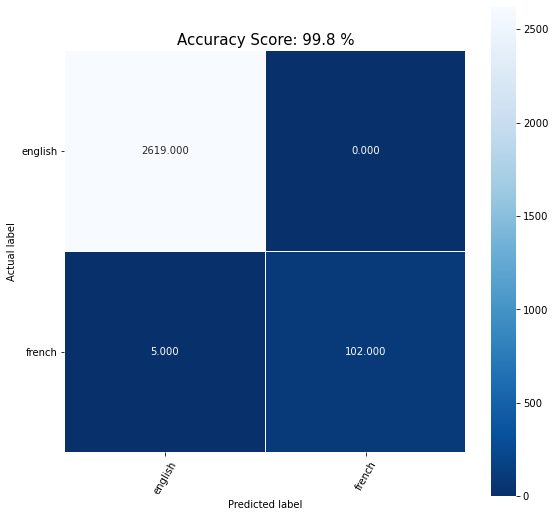

In [33]:
from sklearn import metrics

cm = metrics.confusion_matrix(y, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.yticks(np.arange(len(languages))+0.5, tuple(le.inverse_transform([0, 1])), rotation=0)
plt.ylabel('Actual label');
plt.xticks(np.arange(len(languages))+0.5, tuple(le.inverse_transform([0, 1])), rotation=60)
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0} %'.format(round(score,3)*100)
plt.title(all_sample_title, size = 15);
print(le.inverse_transform([0, 1]))

In [34]:
while True:
    try:
        pred = model.predict([input()])
        print('language :', le.inverse_transform(pred)[0])

    except(KeyboardInterrupt, EOFError, SystemExit):
        break

salut, comment va tu ?
language : french
hi
language : english
hello, how are you
language : english
what's your name
language : english
je
language : french
I
language : english
here we go
language : english
let's go
language : english
je suis là
language : french
quel est ton nom?
language : french
qu'est ce qu'un cable usb
language : french
quit
language : english
